### 0. Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV

### 1. Data loading and understanding

In [2]:
data = pd.read_csv('train.csv')
data.shape

(1460, 81)

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2. Basic EDA

In [4]:
# check null values for each columns

cols_with_null_vals = data.columns[data.isnull().mean() * 100 > 0]
temp = data[cols_with_null_vals].isnull().mean()*100

df_nulls = pd.DataFrame(columns=['feature', '% null values'])
df_nulls['feature'] = temp.index
df_nulls['% null values'] = temp.values

df_nulls

,feature,% null values
0,LotFrontage,17.739726
1,Alley,93.767123
2,MasVnrType,59.726027
3,MasVnrArea,0.547945
4,BsmtQual,2.534247
5,BsmtCond,2.534247
6,BsmtExposure,2.602740
7,BsmtFinType1,2.534247
8,BsmtFinType2,2.602740
9,Electrical,0.068493


In [5]:
# investigate LotFrontage column

data['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [6]:
# imputting null values to columns

data['LotFrontage'] = data['LotFrontage'].fillna(69)

garage_cols = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
data[garage_cols] = data[garage_cols].fillna('No Garage')

basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtFinType1']
data[basement_cols] = data[basement_cols].fillna('No Basement')
basement_cols = ['BsmtExposure', 'BsmtFinType2']
data[basement_cols] = data[basement_cols].fillna('No Basement')

data['Alley'] = data['Alley'].fillna('No Alley')
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data['FireplaceQu'] = data['FireplaceQu'].fillna('No Fireplace')
data['PoolQC'] = data['PoolQC'].fillna('No Pool')
data['Fence'] = data['Fence'].fillna('No Fence')
data['MiscFeature'] = data['MiscFeature'].fillna('No Feature')

In [7]:
# drop Id column

data = data.drop(columns='Id', axis=1)

In [8]:
# check null values in columns

cols_with_null_vals = data.columns[data.isnull().sum() > 0]
data[cols_with_null_vals].isnull().sum()

MasVnrArea    8
Electrical    1
dtype: int64

In [9]:
# delete rows with null values

data = data[(~data['MasVnrArea'].isnull()) & (~data['Electrical'].isnull())]

In [10]:
# check duplicate rows

data[data.duplicated()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [11]:
# change dtype of some incorrect dtypes numeric variables

ord_vars = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']
data[ord_vars] = data[ord_vars].astype('object')

In [12]:
# identify numerical and categorical variables

categorical_vars = data.select_dtypes(include='object').columns
numerical_vars = data.select_dtypes(exclude='object').columns
print('Total categorical features =',categorical_vars.shape[0])
print('Total numerical features =',numerical_vars.shape[0])

Total categorical features = 51
Total numerical features = 29


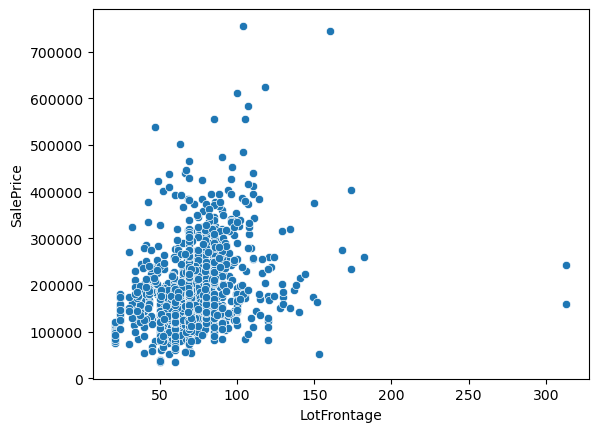

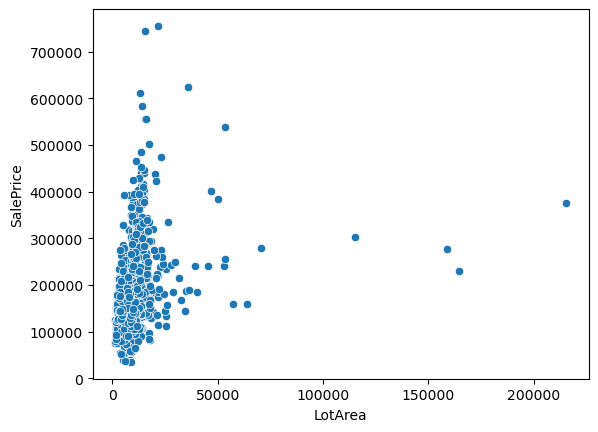

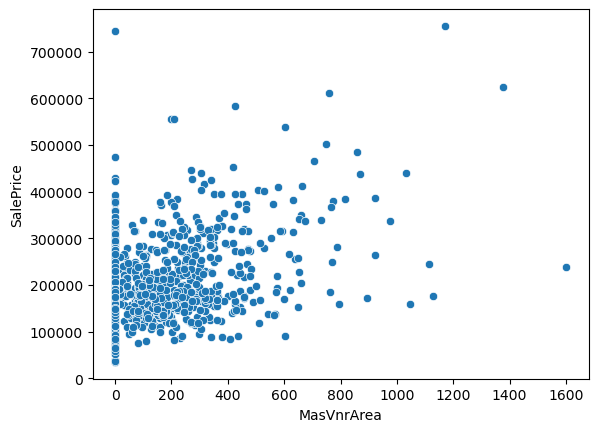

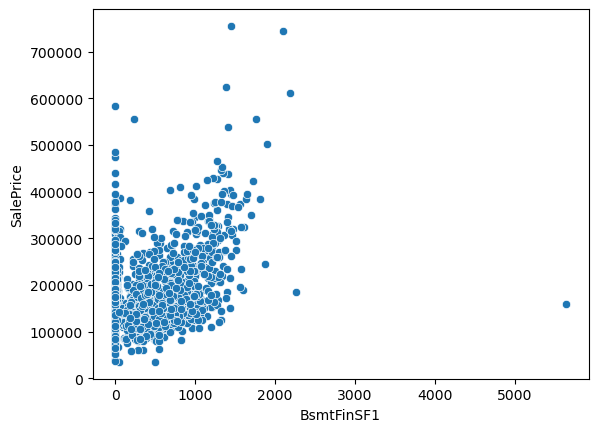

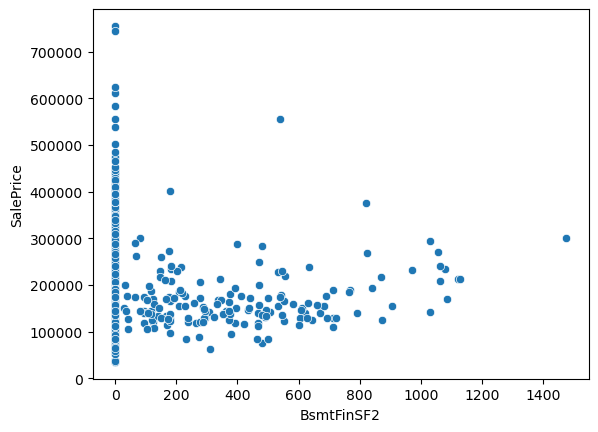

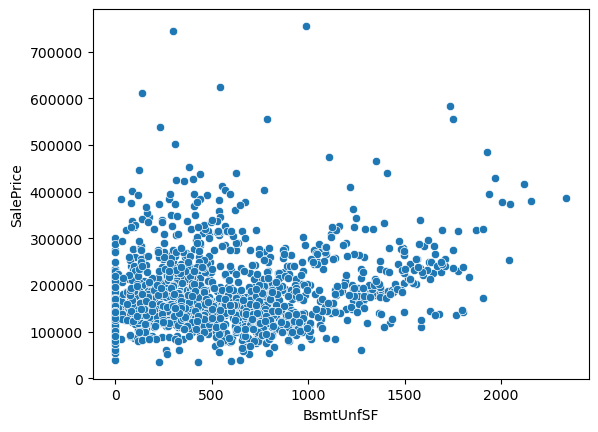

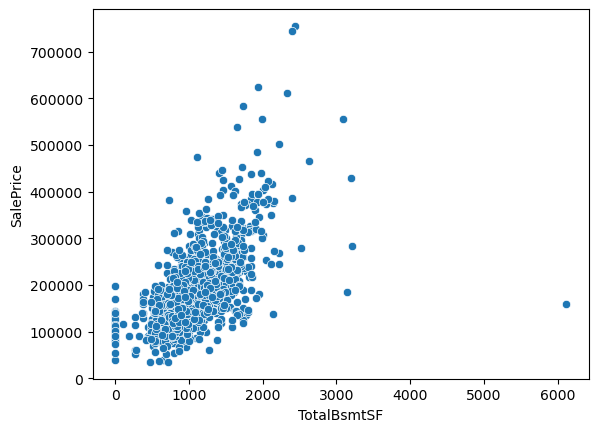

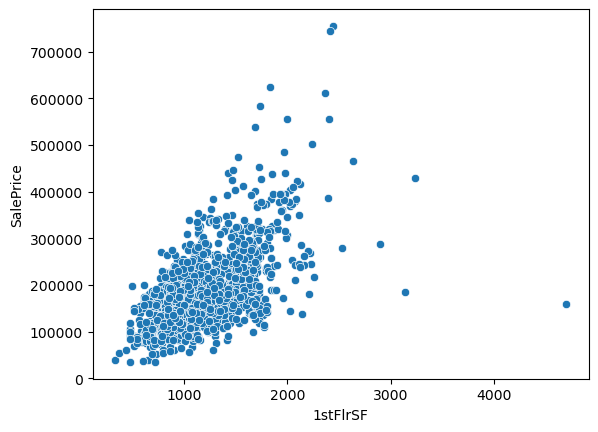

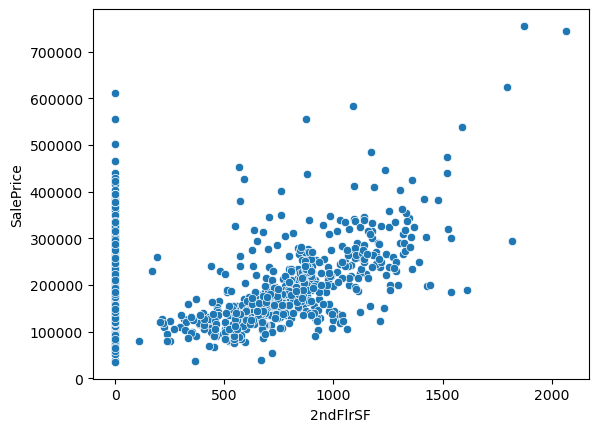

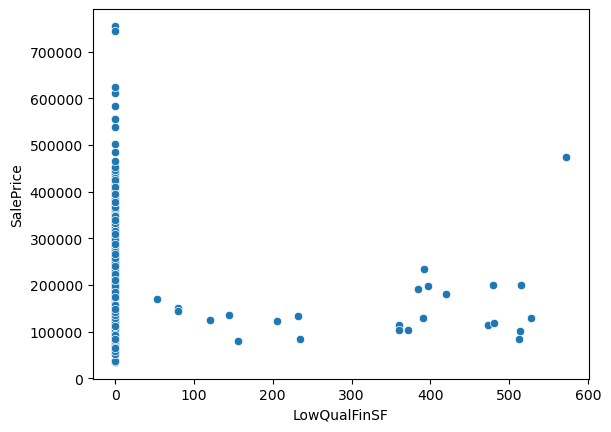

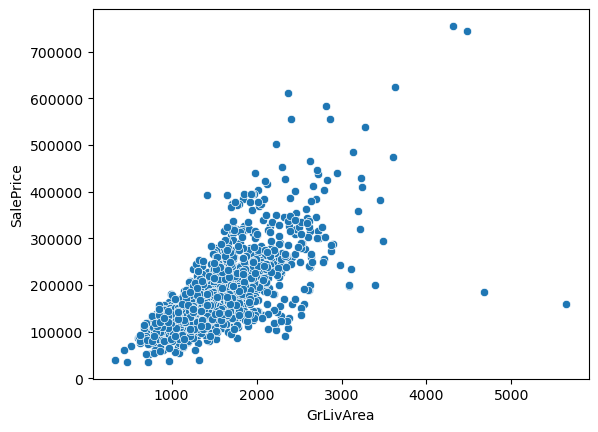

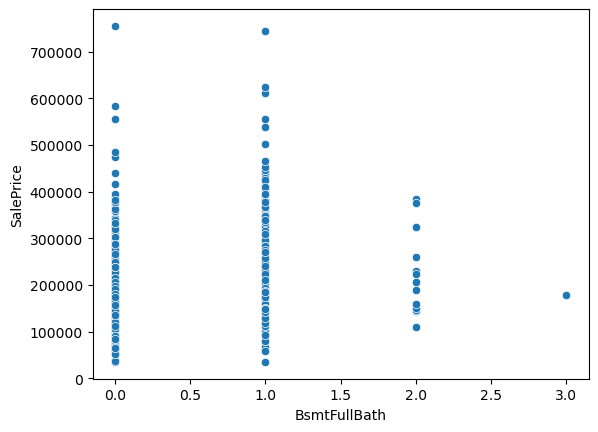

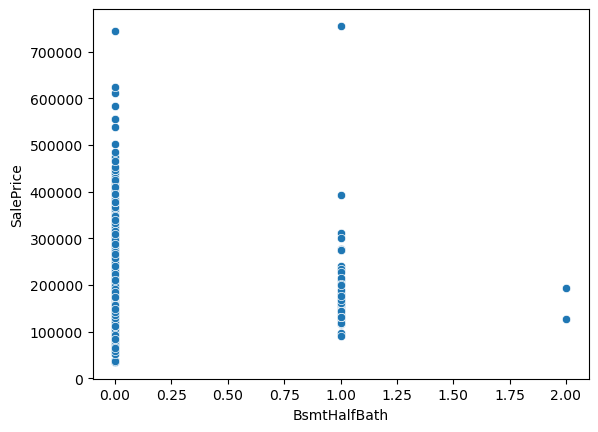

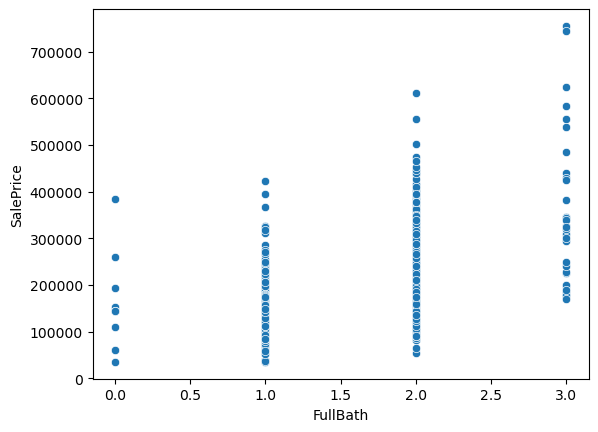

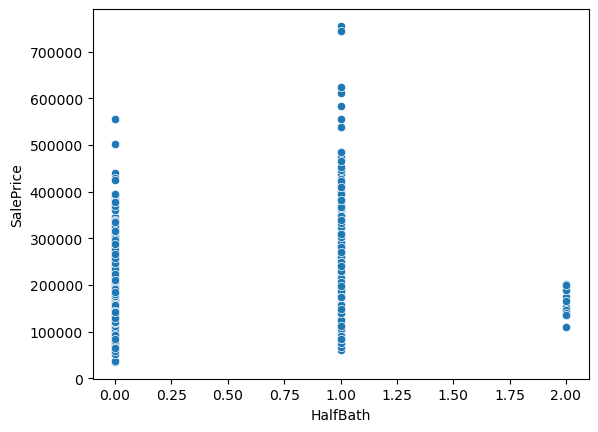

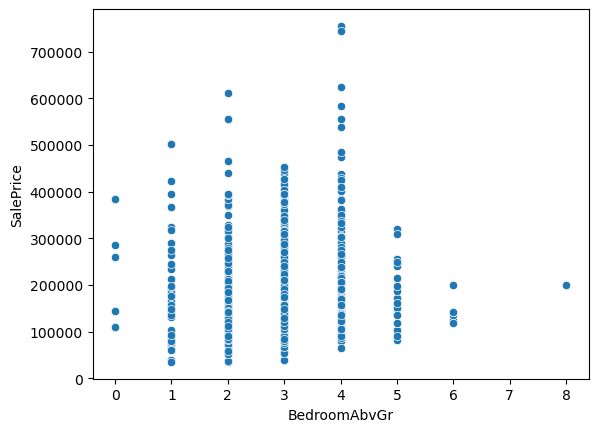

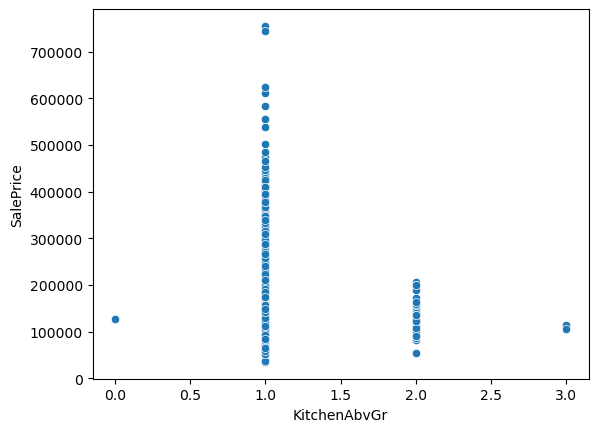

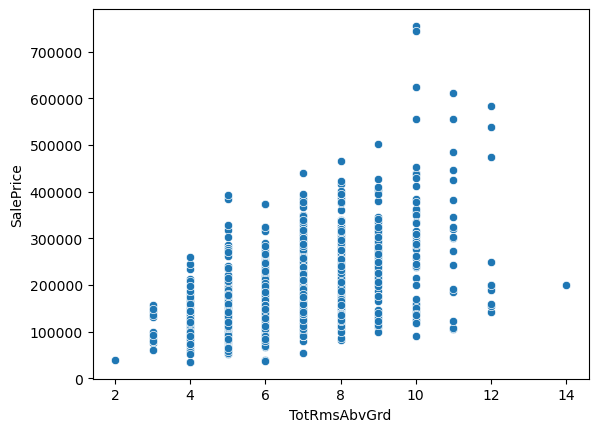

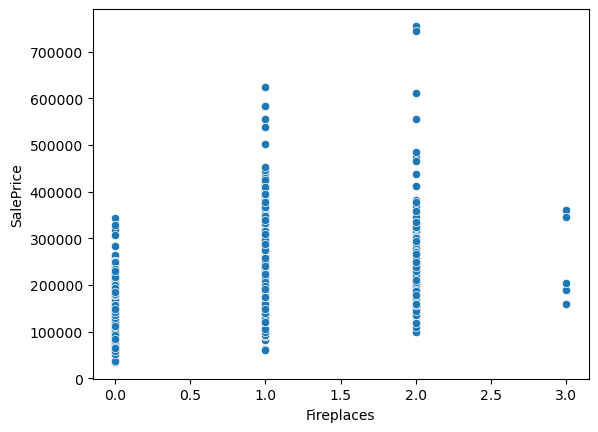

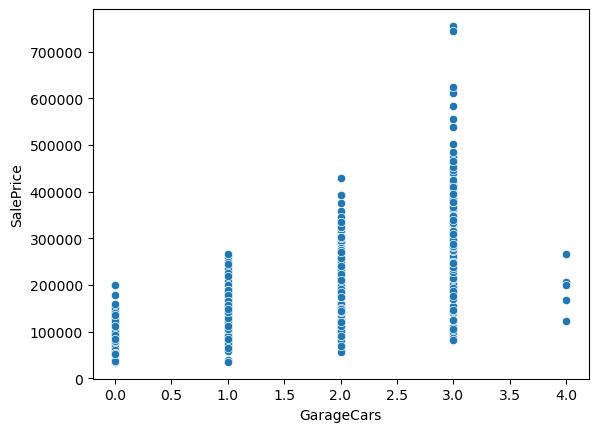

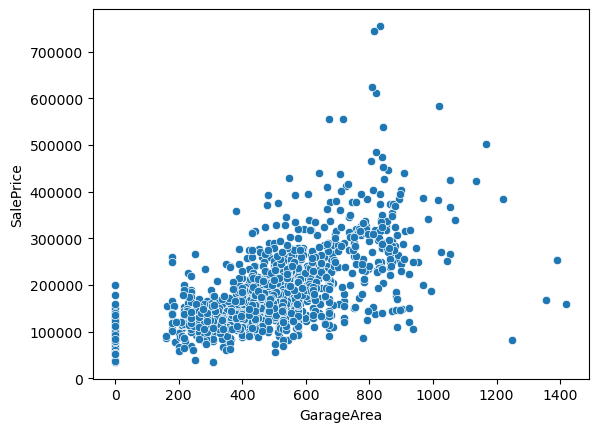

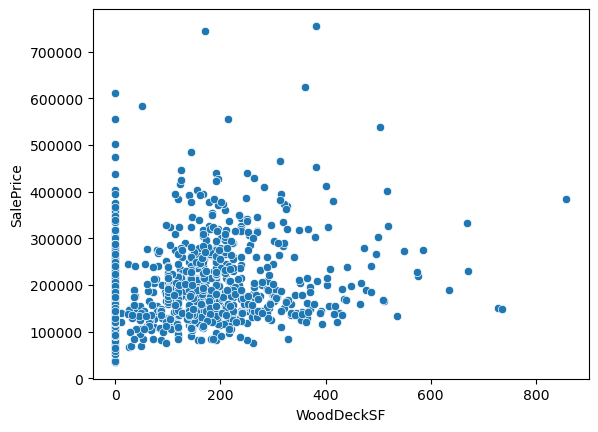

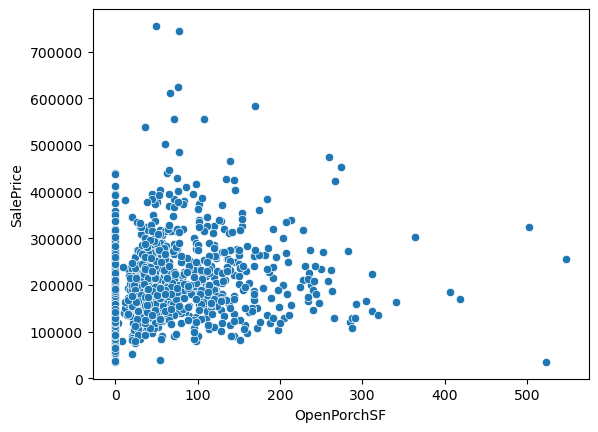

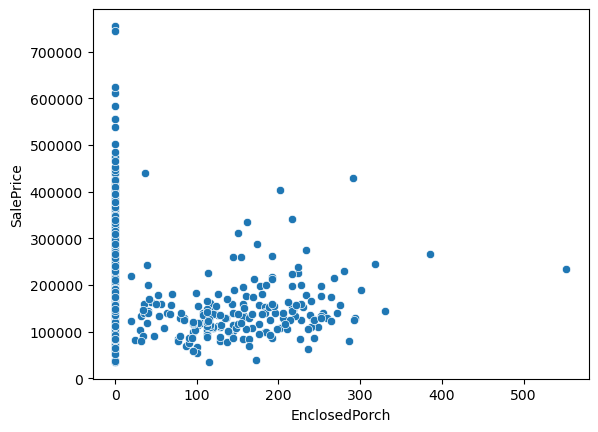

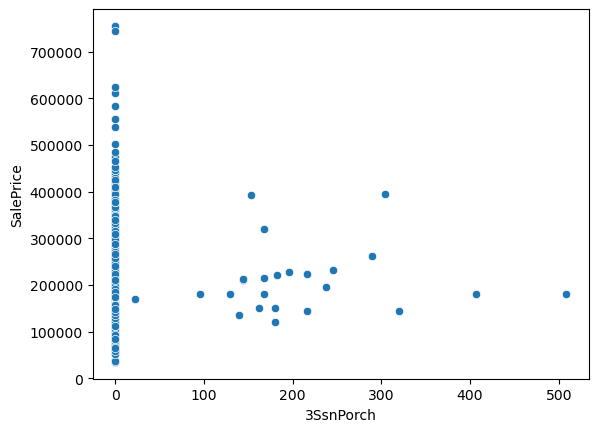

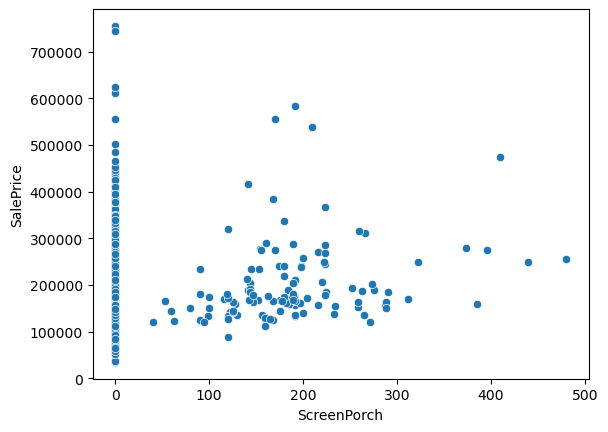

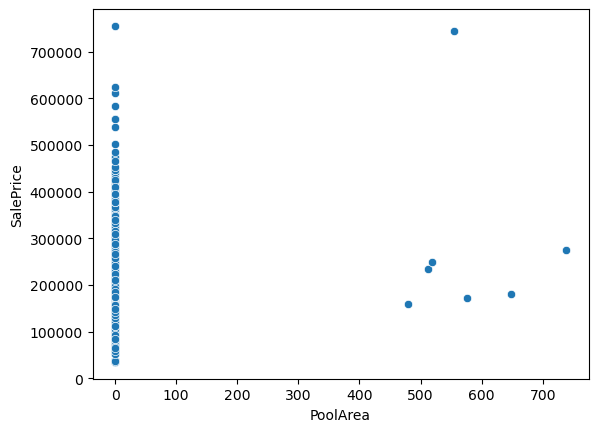

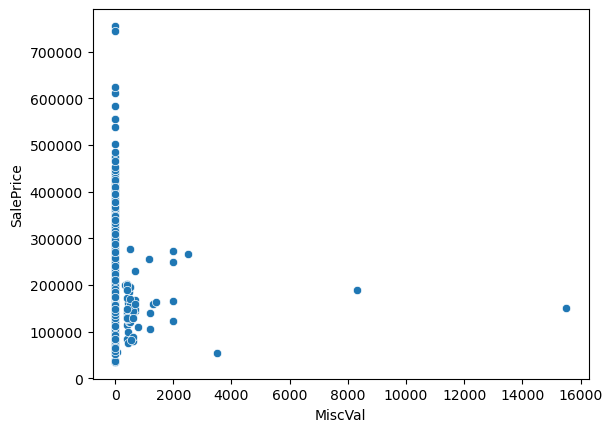

In [13]:
# plot scatter-plot to identify the relation with the target variable

for var in numerical_vars:
    if var != 'SalePrice':
        sns.scatterplot(data, x=var, y='SalePrice')
        plt.show()

From above scatter plots we can see that there is no specific pattern in any of the numeric variable with the target variable. Hence we can use the linear model for the prediction.

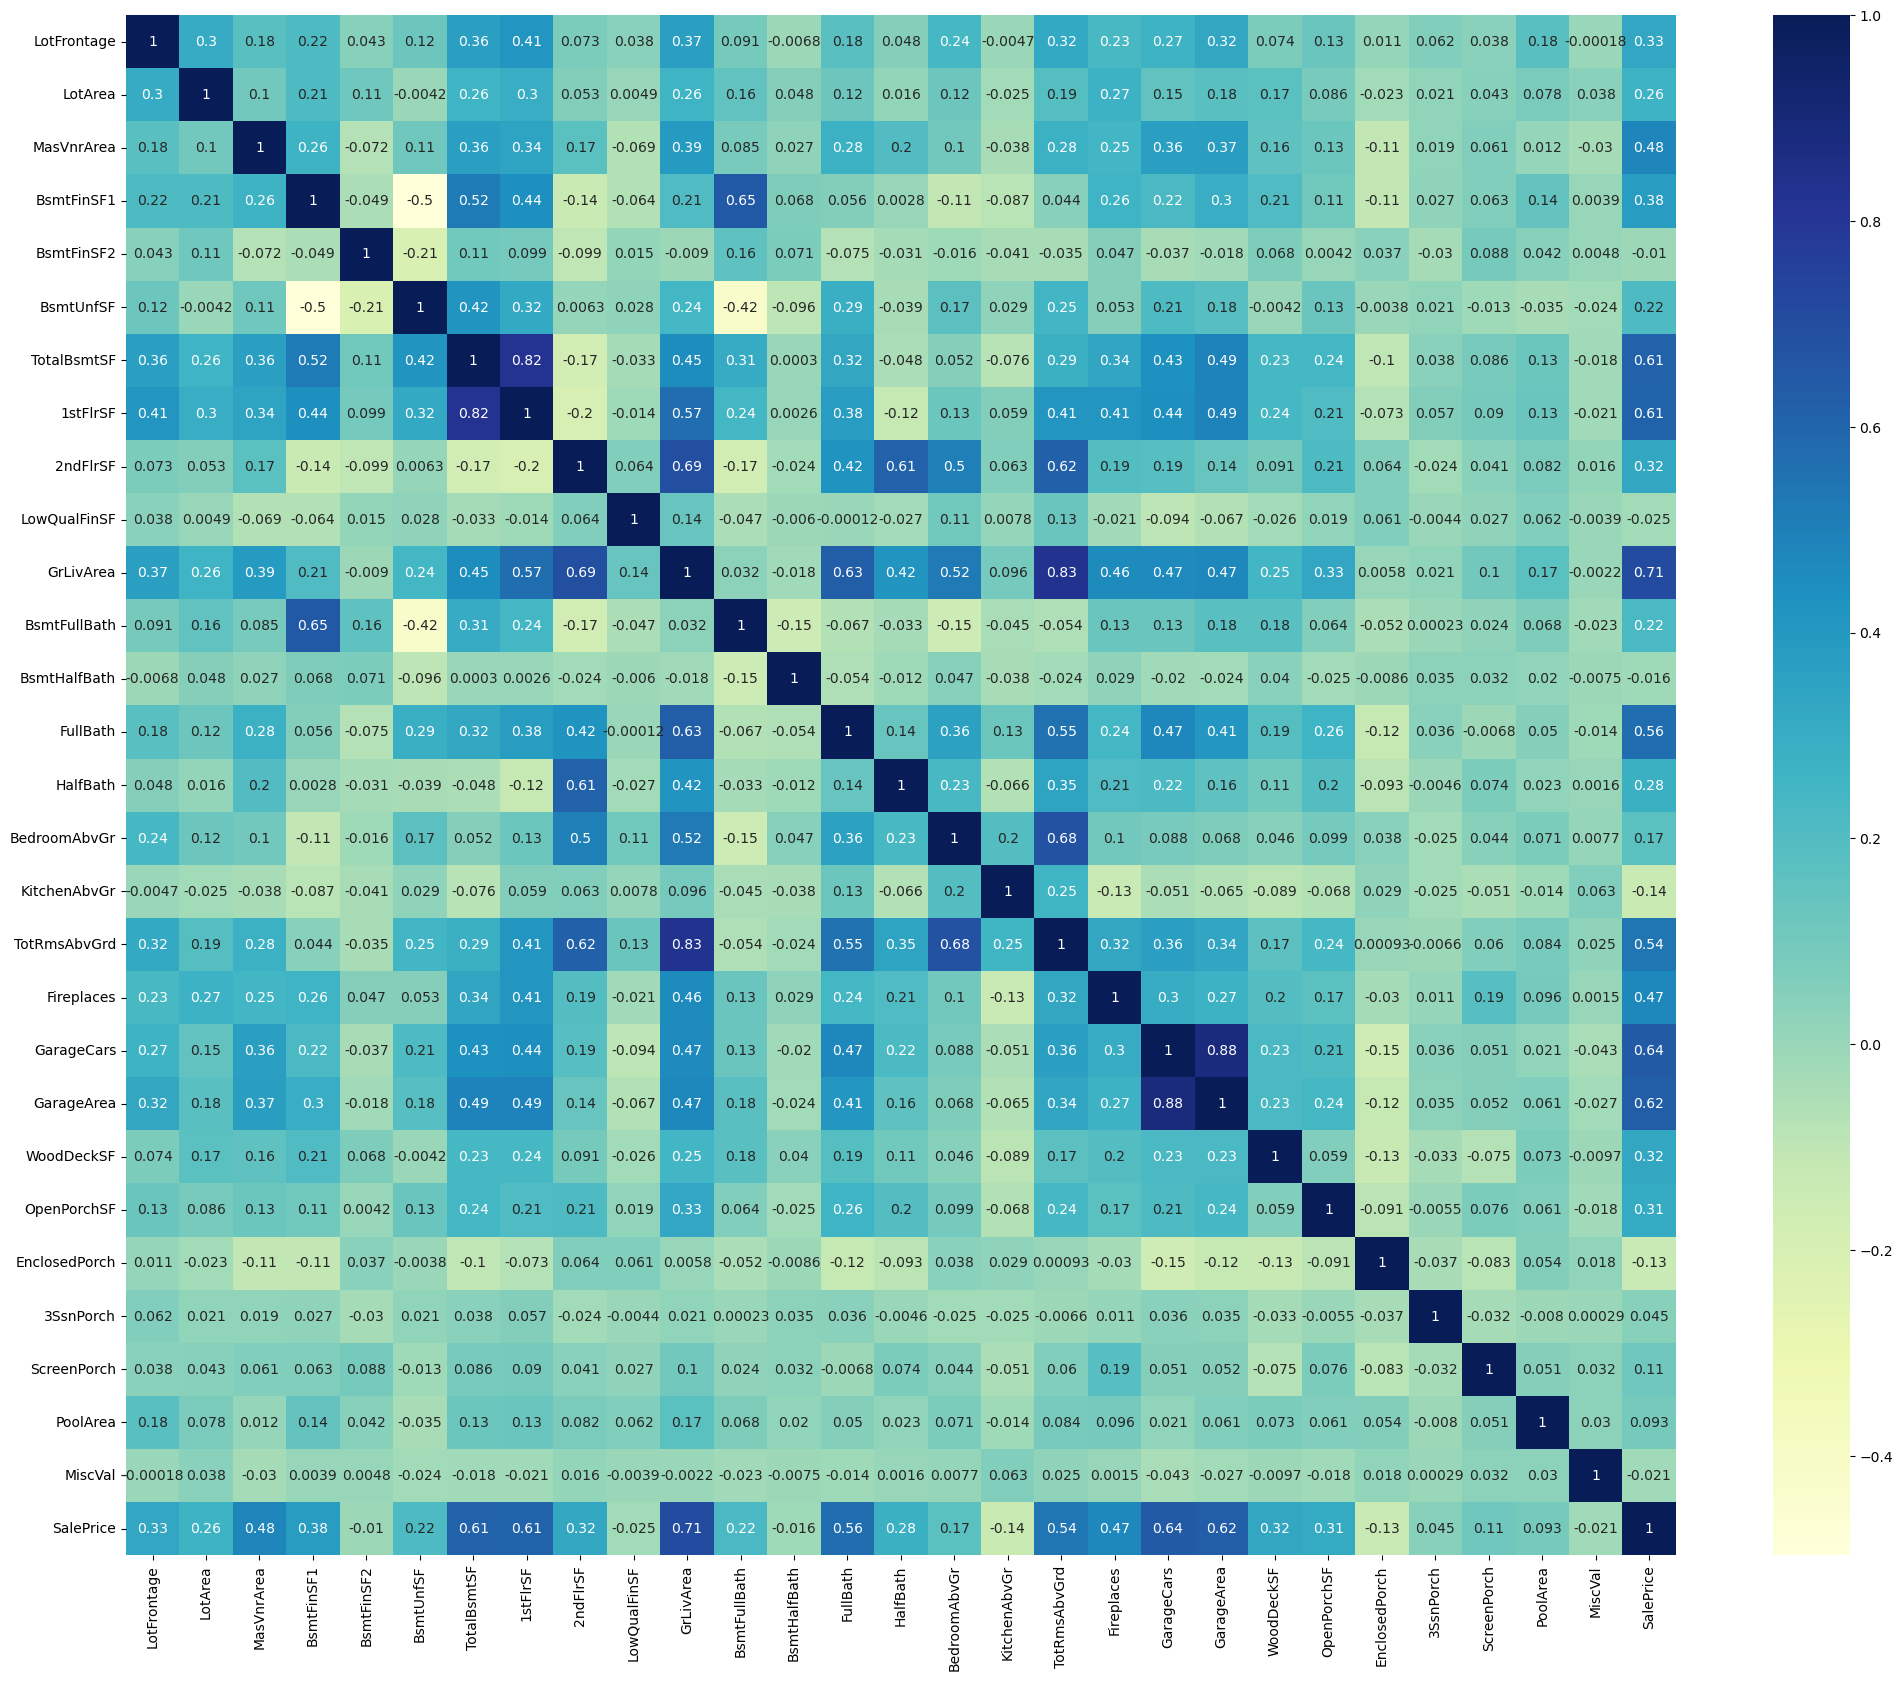

In [14]:
# plot heat map to identify the correlations

plt.figure(figsize=(25, 20))
sns.heatmap(data[numerical_vars].corr(), cmap='YlGnBu', annot=True)
plt.show()

### 3. Data preparation

In [15]:
# identify the binary variables

binary_vars = []

for var in data.columns:
    if len(data[var].unique()) == 2:
        binary_vars.append(var)
        
binary_vars

['Street', 'Utilities', 'CentralAir']

In [16]:
data['Street'].value_counts()

Street
Pave    1445
Grvl       6
Name: count, dtype: int64

In [17]:
data['Utilities'].value_counts()

Utilities
AllPub    1450
NoSeWa       1
Name: count, dtype: int64

In [18]:
data['CentralAir'].value_counts()

CentralAir
Y    1356
N      95
Name: count, dtype: int64

In [19]:
# map binary variables with 0-1

data['Street'] = data['Street'].map({'Pave': 1, 'Grvl': 0})
data['Utilities'] = data['Utilities'].map({'AllPub': 1, 'NoSeWa': 0})
data['CentralAir'] = data['CentralAir'].map({'Y': 1, 'N': 0})

In [20]:
# identify categorical and numerical variables

categorical_vars = data.select_dtypes(include='object').columns
numerical_vars = data.select_dtypes(exclude='object').columns
print('Total categorical features =',categorical_vars.shape[0])
print('Total numerical features =',numerical_vars.shape[0])

Total categorical features = 48
Total numerical features = 32


In [21]:
# handling of categorical variables by adding dummies

data = pd.get_dummies(data, columns=categorical_vars, drop_first=True, dtype='int64')

In [22]:
data.head()

,LotFrontage,LotArea,Street,Utilities,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,1,1,196.0,706,0,150,856,1,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,1,1,0.0,978,0,284,1262,1,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,1,1,162.0,486,0,434,920,1,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,1,1,0.0,216,0,540,756,1,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,1,1,350.0,655,0,490,1145,1,...,0,0,0,0,1,0,0,0,1,0


After adding dummies we have 566 coulumns.

In [23]:
data.describe()

,LotFrontage,LotArea,Street,Utilities,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.00000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,...,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,69.845624,10507.808408,0.995865,0.999311,103.75672,442.274983,46.838043,567.197105,1056.310131,0.934528,...,0.003446,0.003446,0.082012,0.002068,0.869056,0.002757,0.007581,0.013784,0.822192,0.084080
std,22.044429,9992.987081,0.064194,0.026252,181.10815,455.369276,161.777324,442.209192,437.914609,0.247442,...,0.058621,0.058621,0.274478,0.045439,0.337456,0.052450,0.086768,0.116632,0.382483,0.277603
min,21.000000,1300.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7537.500000,1.000000,1.000000,0.00000,0.000000,0.000000,222.000000,795.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,69.000000,9477.000000,1.000000,1.000000,0.00000,381.000000,0.000000,479.000000,991.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,79.000000,11600.000000,1.000000,1.000000,166.00000,707.000000,0.000000,808.000000,1297.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,313.000000,215245.000000,1.000000,1.000000,1600.00000,5644.000000,1474.000000,2336.000000,6110.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Since there is a significant difference in the values of the feature, we must rescale the values.

In [24]:
# split train and test data by 70-30 rule

train_data, test_data = train_test_split(data, train_size=0.7, test_size=0.3, random_state=100)

In [25]:
# apply min max scaling in train and test data

scaler = MinMaxScaler()
train_data[numerical_vars] = scaler.fit_transform(train_data[numerical_vars])
test_data[numerical_vars] = scaler.transform(test_data[numerical_vars])

In [26]:
train_data.describe()

,LotFrontage,LotArea,Street,Utilities,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,...,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,0.167694,0.043382,0.994089,0.999015,0.064786,0.076438,0.043528,0.250238,0.174260,0.936946,...,0.002956,0.002956,0.081773,0.001970,0.867980,0.003941,0.008867,0.008867,0.826601,0.083744
std,0.079066,0.052612,0.076695,0.031388,0.115137,0.082622,0.146236,0.189578,0.072927,0.243180,...,0.054312,0.054312,0.274154,0.044368,0.338679,0.062684,0.093793,0.093793,0.378778,0.277140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.028979,1.000000,1.000000,0.000000,0.000000,0.000000,0.105522,0.130851,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.164384,0.037776,1.000000,1.000000,0.000000,0.061836,0.000000,0.216610,0.161702,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.198630,0.047737,1.000000,1.000000,0.105625,0.123937,0.000000,0.356164,0.212520,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
test_data.describe()

,LotFrontage,LotArea,Street,Utilities,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,436.000000,436.000000,436.0,436.0,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,...,436.000000,436.000000,436.000000,436.000000,436.000000,436.0,436.000000,436.000000,436.000000,436.000000
mean,0.166316,0.042238,1.0,1.0,0.064991,0.082840,0.037842,0.225507,0.169676,0.928899,...,0.004587,0.004587,0.082569,0.002294,0.871560,0.0,0.004587,0.025229,0.811927,0.084862
std,0.066516,0.028615,0.0,0.0,0.108660,0.075877,0.140268,0.187736,0.068635,0.257289,...,0.067651,0.067651,0.275546,0.047891,0.334964,0.0,0.067651,0.157001,0.391220,0.278997
min,0.000000,0.001776,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.030333,1.0,1.0,0.000000,0.000000,0.000000,0.082085,0.127660,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
50%,0.164384,0.038678,1.0,1.0,0.000000,0.080971,0.000000,0.182363,0.164075,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,0.196062,0.048383,1.0,1.0,0.098750,0.130670,0.000000,0.324272,0.211825,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,0.551370,0.324668,1.0,1.0,0.731250,0.337349,1.316071,0.907962,0.400000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [28]:
# create X_train and y_train

X_train = train_data.drop(columns = 'SalePrice', axis=1)
y_train = train_data['SalePrice']
X_train.shape, y_train.shape

((1015, 565), (1015,))

In [29]:
# create X_test and y_test

X_test = test_data.drop(columns = 'SalePrice', axis=1)
y_test = test_data['SalePrice']
X_test.shape, y_test.shape

((436, 565), (436,))

In [30]:
# create penalty parameters for regularization. parameters range from [0.0001 to 900]

alphas = []

for i in range(-4, 3):
    for j in range(1, 10):
        val = j * (10**i)
        alphas.append(round(val, abs(i)))

In [31]:
# define 5-folds using KFold

folds = KFold(n_splits=5, shuffle=True, random_state=100)
param_grid = {'alpha': alphas}

In [32]:
# define a data-frame to store feature coefficients

coefficients = pd.DataFrame()
coefficients['Features'] = X_train.columns

### 4. Ridge regression

In [33]:
# identify the best hyperparameter using cross-validation

cv_ridge = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_absolute_error', cv = folds, return_train_score=True)
cv_ridge.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002,
                                   0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
                                   0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                   0.07, 0.08, 0.09, 0.1, 0.2, 0.3, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [34]:
# best penalty parameter for ridge model is 10

cv_ridge.best_params_

{'alpha': 10}

In [35]:
# create a ridge model with best hyperparameter returned from cross validation

rm = Ridge(alpha=cv_ridge.best_params_['alpha']).fit(X_train, y_train)

In [36]:
# prediction on the train set

y_train_pred = rm.predict(X_train)
r2_score(y_train, y_train_pred)

0.9003709310989558

In [37]:
# prediction on the test set

y_test_pred = rm.predict(X_test)
r2_score(y_test, y_test_pred)

0.8504966146017714

In [38]:
coefficients['Ridge Vals'] = rm.coef_

The `Ridge` model has **train r2score 0.9003** and **test r2score is 0.8505**, which seems good accuracy. Now we need to do residual analysis of this model.

### 5. Residual analysis of ridge model

In [39]:
# identify residuals

err_terms = y_train - y_train_pred

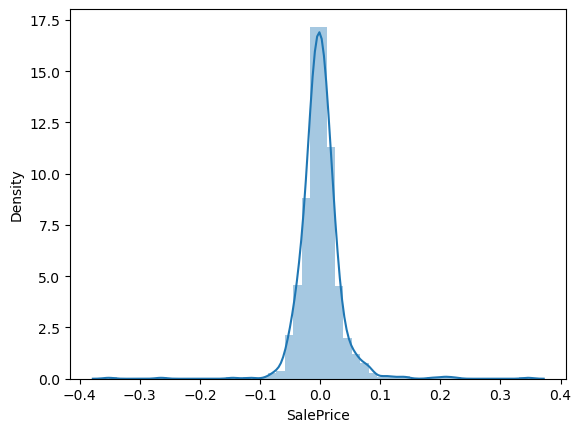

In [40]:
# distribution plot of residuals

sns.distplot(err_terms)
plt.show()

Above graph is showing that the error terms(residuals) are normally distributed over mean = 0.

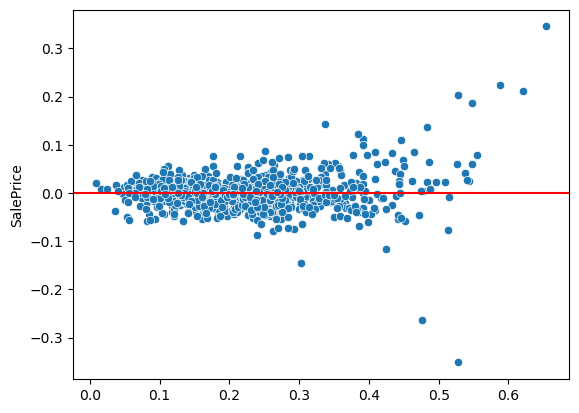

In [41]:
# scatter plot of residuals

sns.scatterplot(x=y_train_pred, y=err_terms)
plt.axhline(y=0, color='red')
plt.show()

Above graph is showing that residuals are randomly scattered with a constant variance. Hence the error terms are homoscedastic in nature.

### 6. Lasso regression

In [42]:
# identify the best hyperparameter using cross-validation

lasso_cv = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_absolute_error', cv = folds, return_train_score=True)
lasso_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002,
                                   0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
                                   0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                   0.07, 0.08, 0.09, 0.1, 0.2, 0.3, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [43]:
# best penalty parameter for ridge model is 0.0002

lasso_cv.best_params_

{'alpha': 0.0002}

In [44]:
# create a lasso model with best hyperparameter returned from cross validation

lm = Lasso(alpha=lasso_cv.best_params_['alpha']).fit(X_train, y_train)

In [45]:
# prediction on train set

y_train_pred = lm.predict(X_train)
r2_score(y_train, y_train_pred)

0.901128144834396

In [46]:
# prediction on test set

y_test_pred = lm.predict(X_test)
r2_score(y_test, y_test_pred)

0.8576601684709291

The `Lasso` model has **train r2score 0.9011** and **test r2score is 0.8576**, which seems good accuracy and slightly better than ridge model. Now we need to do residual analysis of this model.

### 7. Residual analysis of lasso model

In [47]:
# compute residuals

err_terms = y_train - y_train_pred

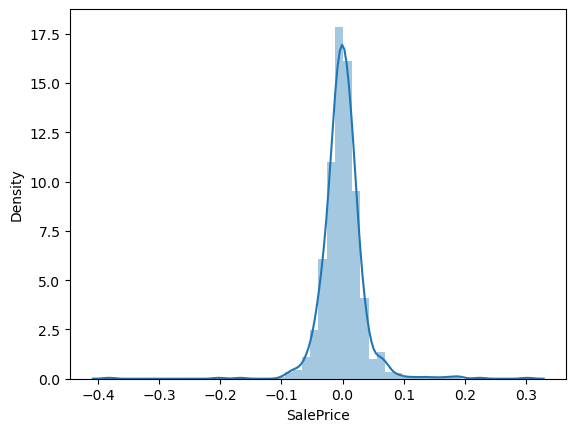

In [48]:
# distribution plot of residuals

sns.distplot(err_terms)
plt.show()

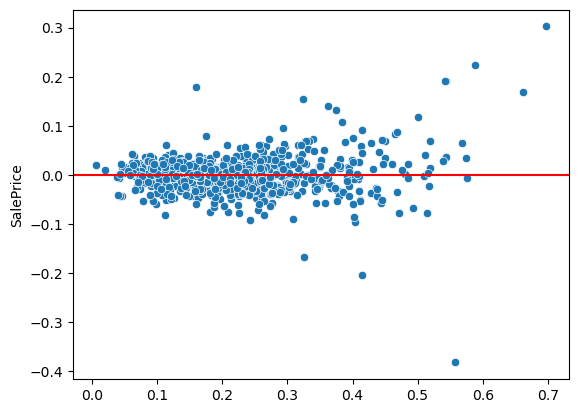

In [49]:
# distribution plot of residuals

sns.scatterplot(x=y_train_pred, y=err_terms)
plt.axhline(y=0, color='red')
plt.show()

In [50]:
coefficients['Lasso Vals'] = lm.coef_

### 8. Results

In [51]:
# regression coefficients

pd.set_option('display.max_rows', 110)
coefficients[coefficients['Lasso Vals'] != 0].sort_values(by='Lasso Vals', ascending=False)

,Features,Ridge Vals,Lasso Vals
13,GrLivArea,0.048032,0.315847
121,OverallQual_10,0.047356,0.125369
120,OverallQual_9,0.053592,0.115666
22,GarageCars,0.046469,0.069368
77,Neighborhood_NoRidge,0.042958,0.046216
...,...,...,...
123,OverallCond_3,-0.015300,-0.016027
104,BldgType_Twnhs,-0.015568,-0.016150
396,KitchenQual_TA,-0.026383,-0.018025
527,PoolQC_Gd,-0.026526,-0.118179
